# サンプルモデル

In [1]:
import numpy as np
def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x

In [2]:
print(sample())
print(sample())
print(sample())

9
9
10


In [3]:
# たくさんサンプリングを行って平均をとるのがモンテカルロ法
trial = 100

samples = []
for _ in range(trial):
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples)  # 平均を求める
print(V)

6.81


In [4]:
# サンプルデータを得るたびに平均値を求める
trial = 10

samples = []
for _ in range(trial):
    s = sample()
    samples.append(s)
    V = sum(samples) / len(samples)
    print(V)

7.0
5.0
7.0
6.75
7.0
6.833333333333333
6.714285714285714
6.875
6.777777777777778
7.0


In [5]:
# 上と同じことをインクリメンタルな式で行う
trial = 10
V, n = 0, 0
for _ in range(trial):
    s = sample()
    n += 1
    V += (s - V) / n
    print(V)

7.0
5.5
5.666666666666667
6.0
7.2
7.5
7.428571428571429
7.75
7.333333333333333
7.3999999999999995


# モンテカルロ法による方策評価

In [6]:
# stepメソッドの使い方
from common.gridworld import GridWorld

env = GridWorld()
action = 0  # ダミーの行動
next_state, reward, done = env.step(action)

print('next_state:', next_state)
print('reward:', reward)
print('done:', done)

next_state: (1, 0)
reward: 0
done: False


In [7]:
# resetメソッドも用意している
env = GridWorld()
state = env.reset()

In [8]:
# エージェントクラスの実装
from collections import defaultdict
class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.experience = []

    # 確率に従い行動を決定
    def get_action(self, state):
        ps = self.pi[state]
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)
    
    # 行動や報酬を記録
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.experience.append(data)

    def reset(self):
        self.experience = []

    # モンテカルロ法を実行
    def eval(self):
        g = 0
        for data in reversed(self.experience):  # 逆向きにたどる
            state, action, reward = data
            g = self.gamma * g + reward
            self.cnts[state] += 1
            self.V[state] += (g - self.V[state]) / self.cnts[state]  # インクリメンタルな実装

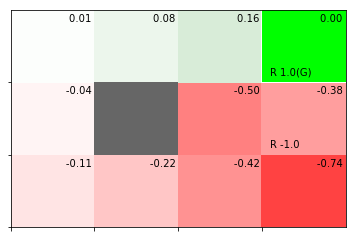

In [9]:
# モンテカルロ法を動作
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, next_reward, done = env.step(action)

        agent.add(state, action, next_reward)
        if done:
            agent.eval()
            break

        state = next_state

env.render_v(agent.V)

# モンテカルロ法を使った方策制御

In [10]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1  # ε-greedyのε
        self.alpha = 0.1  # Q値を更新する際の固定値alpha
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.experience = []

    def get_action(self, state):
        ps = self.pi[state]
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        self.experience.append((state, action, reward))

    def reset(self):
        self.experience.clear()

    def update(self):
        g = 0
        for data in reversed(self.experience):
            state, action, reward = data
            g = self.gamma * g + reward
            key = (state, action)
            self.Q[key] += (g - self.Q[key]) * self.alpha  # 固定値alphaで更新
            self.pi[state] = greedy_action_probs(self.Q, state, self.epsilon)

In [11]:
# Q関数が最大の行動をとる確率を1とする
def greedy_action_probs(Q, state, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    action_probs = {action:0.0 for action in range(action_size)}  #{0:0.0, 1:0.0, 2:0.0, 3:0.0}
    action_probs[max_action] = 1
    return action_probs

In [12]:
# 上記の関数をε-greedyに修正
def greedy_action_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

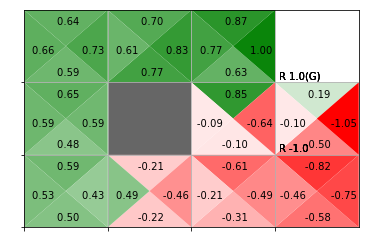

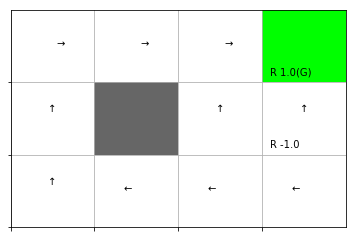

In [13]:
env = GridWorld()
agent = McAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

# 重点サンプリング

In [14]:
import numpy as np

x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# 期待値
e = np.sum(x * pi)
print('E_pi[x]', e)

# モンテカルロ法
n = 100
samples = []
for i in range(n):
    s = np.random.choice(x, p=pi)  # piを使ってサンプリング
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)
print('MC: {:.2f} (var: {:.2f})'.format(mean, var))

E_pi[x] 2.7
MC: 2.68 (var: 0.42)


In [15]:
b = np.array([1/3, 1/3, 1/3])
n = 100
samples = []

for i in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)  # bを使ってサンプリング
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

print('IS: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

IS: 2.95 (var: 10.64)


In [16]:
b = np.array([0.2, 0.2, 0.6])  # 確率分布を変更
samples = []
for i in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)
    
print('IS: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

IS: 2.75 (var: 2.49)


# 方策オフ型エージェント

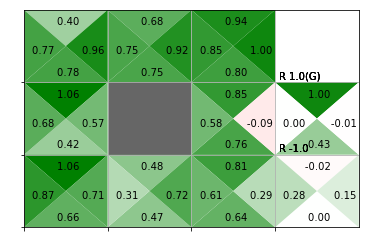

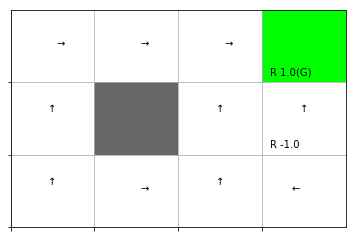

In [17]:
import numpy as np
from common.gridworld import GridWorld


class McOffPolicyAgent(McAgent):  # McAgentクラスを継承
    def __init__(self):
        super().__init__()
        self.b = self.pi.copy()  # ランダムな方策で初期化

    def get_action(self, state):
        ps = self.b[state] # 挙動方策で行動
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def update(self):
        g = 0
        rho = 1 # サンプルデータとして得られた収益は重みrhoで補正が必要

        for data in reversed(self.experience):
            state, action, reward = data
            key = (state, action)

            # サンプルデータを使って学習（Q値を更新、方策を改善）
            g = self.gamma * rho * g + reward
            self.Q[key] += (g - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            # piはgreedy、bはε-greedy で更新
            self.pi[state] = greedy_action_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_action_probs(self.Q, state, self.epsilon)


 
env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)